# Specific game attributes for SIL Test

In [1]:
%pylab inline
import scipy.stats as stats
import itertools
import pandas as pd
import networkx as nx
from lifelines import CoxTimeVaryingFitter
import json
from collections import Counter
from measure_experiment import *

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [2]:
export_dir = "../../results-anonymized/SIL_test/NaiveBots//"
players = []
with open(export_dir + 'players.jsonl', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.jsonl', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.jsonl', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.jsonl', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2020-06-01T12:20:36.238Z panel_0_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
1 2020-06-01T12:20:36.481Z panel_0_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
2 2020-06-01T12:22:02.231Z panel_1_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
3 2020-06-01T12:22:02.446Z panel_1_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
4 2020-06-01T12:30:14.409Z panel_2_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
5 2020-06-01T12:30:14.592Z panel_2_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
6 2020-06-01T12:30:15.084Z panel_3_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
7 2020-06-01T12:30:15.326Z panel_3_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
8 2020-06-01T12:39:19.456Z panel_4_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
9 2020-06-01T12:39:19.741Z panel_4_matched_pair_exp_design6_matched_bots_20200521_11542

In [11]:
# select which games to process
# Game 1 was a test game, for practice

select = [1]
process_games = [loaded_games[i] for i in select]
for game in process_games:
    print(i, game['createdAt'], game['gameSetupId'])

83 2020-06-01T12:20:36.481Z panel_0_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots


In [12]:
for player_id, player in game['players'].items():
    if 'workerId' in player['urlParams'].keys():
        player['name'] = player['urlParams']['workerId']
    else:
        player['name'] = player['id']

In [13]:
t_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='t']
c_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='c']

In [14]:
game.keys()

dict_keys(['_id', 'finishedAt', 'gameLobbyId', 'treatmentId', 'roundIds', 'playerIds', 'batchId', 'createdAt', 'data.nodes', 'data.clues', 'data.network', 'data.gameSetupId', 'players', 'gameSetupId', 'log'])

In [15]:
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

game_log = pd.DataFrame(game['log'])
game_log['logTime'] = game_log['createdAt'].apply(lambda s: datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ'))
game_log['t'] = game_log['logTime'] - t_start
game_log

,_id,playerId,gameId,roundId,stageId,name,jsonData,createdAt,data,logTime,t
0,REub2uBLMwYoc3jcN,a4ukDvgvan5vRWPKy,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""cclue_3_8"",""source"":"""",""dest"":""promis...",2020-06-01T12:20:38.575Z,"{'clue': 'cclue_3_8', 'source': '', 'dest': 'p...",2020-06-01 12:20:38.575,00:00:02.094000
1,7ggk59LQGcz4zhePx,7SZWX9LgA82nCsXjF,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""tclue_7_8"",""source"":"""",""dest"":""promis...",2020-06-01T12:20:38.809Z,"{'clue': 'tclue_7_8', 'source': '', 'dest': 'p...",2020-06-01 12:20:38.809,00:00:02.328000
2,xX7mf4Xrj7ihXRtxd,SzSy8M9SxNeXyfpxf,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""tclue_7_11"",""source"":"""",""dest"":""promi...",2020-06-01T12:20:40.646Z,"{'clue': 'tclue_7_11', 'source': '', 'dest': '...",2020-06-01 12:20:40.646,00:00:04.165000
3,EntYXj3puwbF5mSTP,DNhL5RW4HDWmnfTMn,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""cclue_3_11"",""source"":"""",""dest"":""promi...",2020-06-01T12:20:41.589Z,"{'clue': 'cclue_3_11', 'source': '', 'dest': '...",2020-06-01 12:20:41.589,00:00:05.108000
4,9umtpApjaGeBq2K6t,7SZWX9LgA82nCsXjF,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""tclue_7_11"",""source"":"""",""dest"":""promi...",2020-06-01T12:20:45.686Z,"{'clue': 'tclue_7_11', 'source': '', 'dest': '...",2020-06-01 12:20:45.686,00:00:09.205000
...,...,...,...,...,...,...,...,...,...,...,...
499,qqLyebiGFbBT4h999,yBtywjBxacbBjquAp,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""cclue_9_11"",""source"":"""",""dest"":""promi...",2020-06-01T12:28:35.034Z,"{'clue': 'cclue_9_11', 'source': '', 'dest': '...",2020-06-01 12:28:35.034,00:07:58.553000
500,44HDJmihkK8NrbBdX,767pje7ysLJsiRgeu,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""cclue_1_4"",""source"":"""",""dest"":""promis...",2020-06-01T12:28:35.154Z,"{'clue': 'cclue_1_4', 'source': '', 'dest': 'p...",2020-06-01 12:28:35.154,00:07:58.673000
501,iBAJcFvX9dEfASC3h,8FQNzuvqw9YbRwPEK,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""tclue_8_10"",""source"":"""",""dest"":""promi...",2020-06-01T12:28:36.250Z,"{'clue': 'tclue_8_10', 'source': '', 'dest': '...",2020-06-01 12:28:36.250,00:07:59.769000
502,h6erxDc9pEMZntnDH,afe5jPiq3vrxt3Msf,t8FTCKE5N8nrbiDbk,F2fvintXDnyW8jnxy,StM4Jm2yFeL3gNqj2,drop,"{""clue"":""tclue_8_12"",""source"":"""",""dest"":""promi...",2020-06-01T12:28:36.280Z,"{'clue': 'tclue_8_12', 'source': '', 'dest': '...",2020-06-01 12:28:36.280,00:07:59.799000


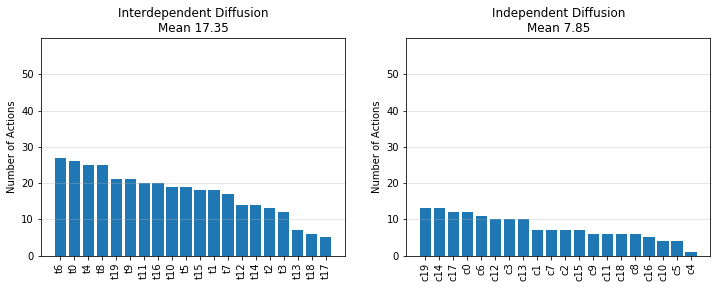

In [16]:
plt.figure(figsize=(12,4))

counts = game_log[game_log['name'] == 'drop'][['playerId', '_id']].groupby('playerId').count()

log_length = {}
for pid in t_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,1)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Interdependent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

log_length = {}
for pid in c_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,2)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Independent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

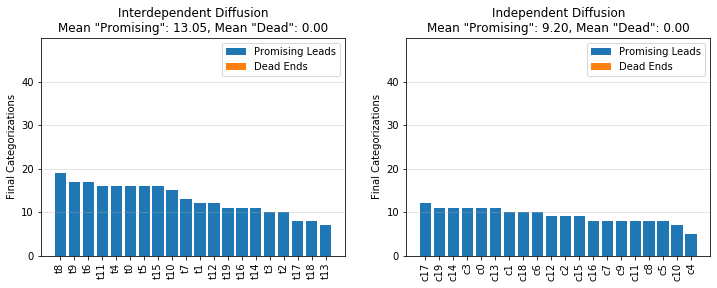

In [17]:
plt.figure(figsize=(12,4))

promising = {}
dead = {}
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,1)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Interdependent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));


promising = {}
dead = {}
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,2)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Independent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));

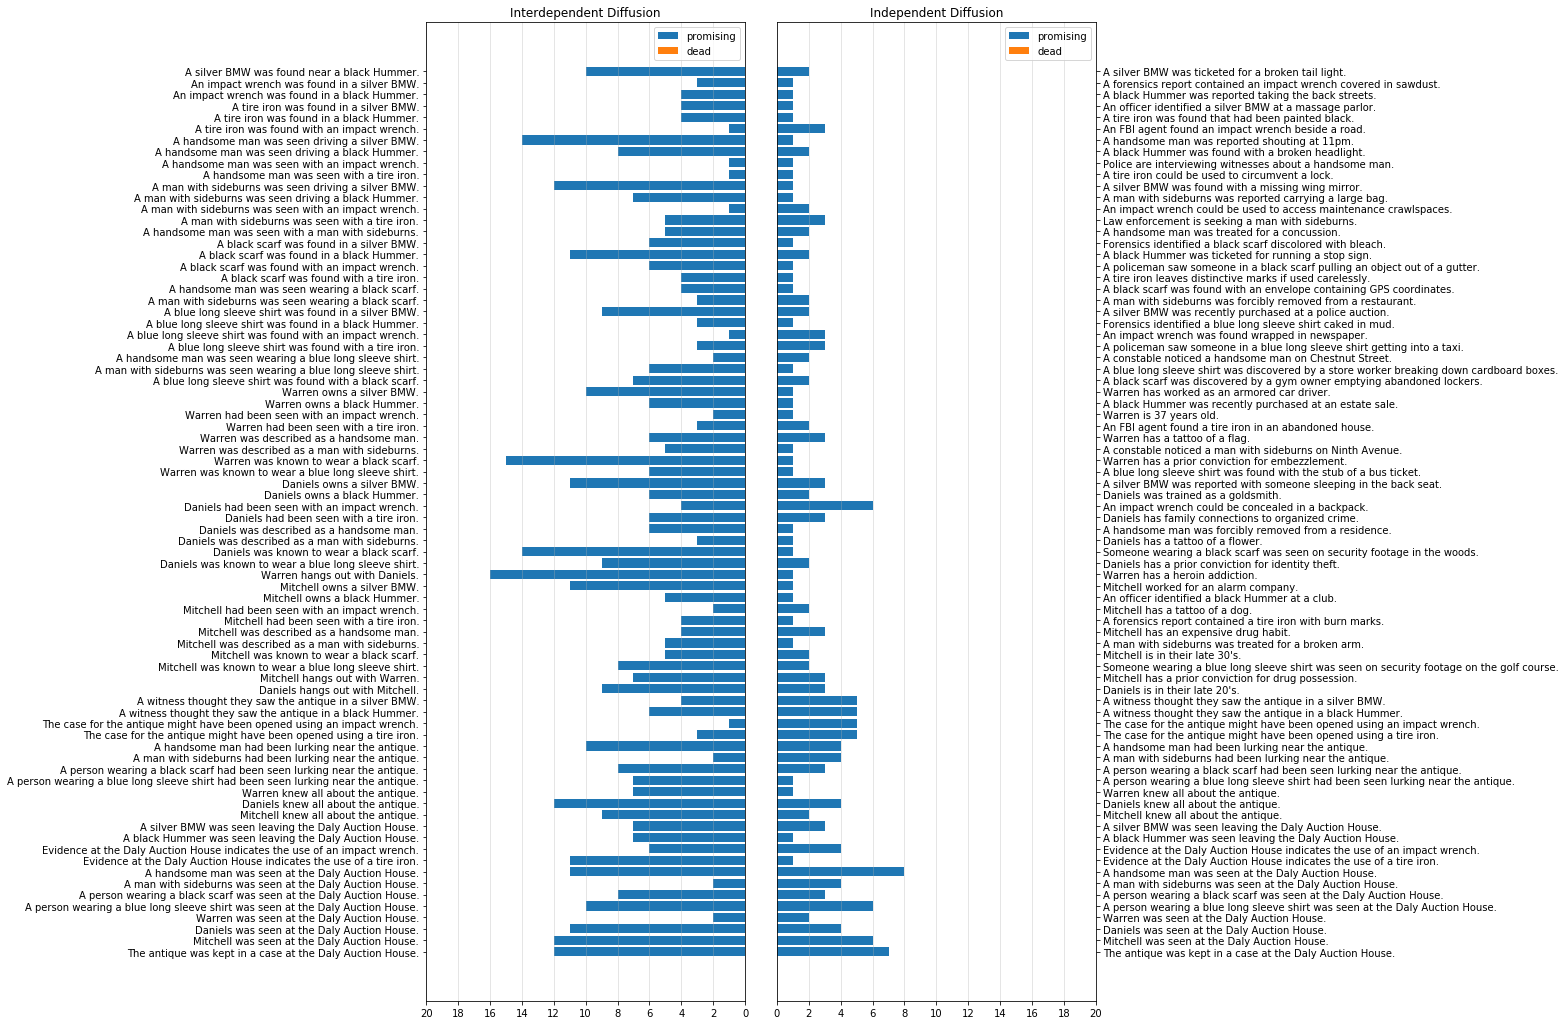

In [10]:

plt.figure(figsize=(12,18))

promising = Counter()
dead = Counter()
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1
            
axl = plt.subplot(1,2,1)       
#order = list(set(promising.keys()).union(set(dead.keys())))
order = [k for k in game['data.clues'].keys() if k[0]=='t']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.box('off')
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.grid('on', axis='x', alpha=.4)
plt.title('Interdependent Diffusion');
axl.invert_xaxis()
inter_promising = promising
inter_order = order

promising = Counter()
dead = Counter()
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1

axr = plt.subplot(1,2,2)       
order = [k for k in game['data.clues'].keys() if k[0]=='c']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.box('off')
plt.grid('on', axis='x', alpha=.4)
plt.title('Independent Diffusion');
axr.yaxis.tick_right()
plt.subplots_adjust(wspace=.1)

indep_promising = promising
indep_order = order


In [30]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in inter_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Treatment: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([inter_promising[cl] for cl in spoke])/23, np.sum([inter_promising[cl] for cl in nonspoke])/55))

spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in indep_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Control: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([indep_promising[cl] for cl in spoke])/23, np.sum([indep_promising[cl] for cl in nonspoke])/55))

Treatment: 4.09 adoptions per spoke, 2.85 adoptions per nonspoke
Control: 2.35 adoptions per spoke, 1.85 adoptions per nonspoke


1.4328049611551374

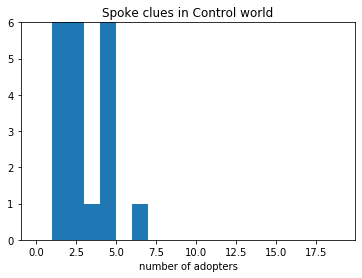

In [31]:
spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([indep_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Control world')
#len(spoke)
#sum([indep_promising[cl] for cl in spoke])
np.std([indep_promising[cl] for cl in spoke])

2.8576829087226057

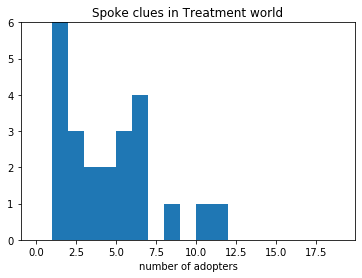

In [32]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([inter_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Treatment world')
#len(spoke)
#sum([inter_promising[cl] for cl in spoke])
np.std([inter_promising[cl] for cl in spoke])

# Retrace logs

(0, 0.6825)

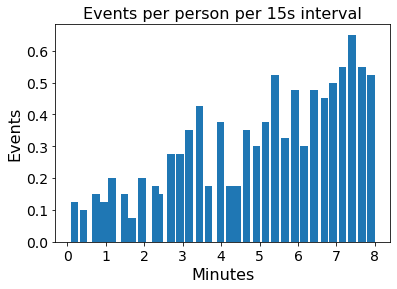

In [36]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
#            assert source in game['playerIds']  # check that source is another player
#            if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
#                # this can fail if the exposer removes the clue while the exposed is dragging it.
#                # turns out not to be a big deal
#                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       



ts = list(range(0,9*60,15))
events = 0
xs = []
events_list = []

for (player_id, g, t) in retrace(game):
    if t >= ts[0]:
        events_list.append(events)
        xs.append(t)
        ts.pop(0)
    events+=1


plt.bar(xs[1:], np.diff(events_list)/40, width=-12, align='edge')
plt.title("Events per person per 15s interval", fontsize=16)
plt.xlabel("Minutes", fontsize=16)
plt.ylabel("Events", fontsize=16)
plt.xticks(range(0, 481, 60), range(0,9), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0)